# Convolutional Neural Networks (CNN) with PyTorch

This part of the assignment is about implementing a Convolutional Neural Network (CNN) using PyTorch. We will be using a dataset of images of pokemon and predicting their type. 

The dataset will be found in the `data` folder.

# Imports

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from tqdm.notebook import tqdm
from scipy.optimize import linear_sum_assignment
from torch.nn.functional import cross_entropy, l1_loss
from torchvision.ops.boxes import box_area
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch
from torch.utils.data.dataloader import default_collate
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.functional import l1_loss
from torch.nn.functional import cross_entropy
import json


# Creating dataset class



In [5]:


class CustomDataset(Dataset):
    def __init__(self, img_folder, annotations_file, results_file, transform=None):
        self.img_folder = img_folder
        self.transform = transform
        self.annotations = self.load_json(annotations_file)
        self.results = self.load_json(results_file)
        self.img_ids = [img['id'] for img in self.annotations['images']]

    @staticmethod
    def load_json(filename):
        with open(filename) as f:
            return json.load(f)

    def load_image(self, file_path):
        # Image loading needs to be handled according to the image format and library used.
        image = Image.open(file_path).convert('RGB')
        return image

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        img_info = next(img for img in self.annotations['images'] if img['id'] == img_id)
        img_path = f"{self.img_folder}/{img_info['file_name']}"
        image = self.load_image(img_path)

        anns = [ann for ann in self.annotations['annotations'] if ann['image_id'] == img_id]
        results = [res for res in self.results if res['image_id'] == img_id]

        gt_boxes, gt_labels = [], []
        pred_boxes, pred_labels = [], []

        for ann in anns:
            bbox = ann['bbox']
            gt_boxes.append([bbox[0] / 640, bbox[1] / 640, (bbox[0] + bbox[2]) / 640, (bbox[1] + bbox[3]) / 640])
            gt_labels.append(ann['category_id'])

        for result in results:
            pred_box = result['bbox']
            pred_boxes.append([pred_box[0] / 640, pred_box[1] / 640, (pred_box[0] + pred_box[2]) / 640, (pred_box[1] + pred_box[3]) / 640])
            pred_labels.append(result['category_id'])
        if anns == []:
            gt_boxes = [[0, 0, 0, 0]]
            gt_labels = [2]
        if results == []:
            pred_boxes = [[0, 0, 0, 0]]
            pred_labels = [2]
            
        max_boxes = max(len(gt_boxes), len(pred_boxes))
        gt_boxes += [[0, 0, 0, 0]] * (max_boxes - len(gt_boxes))
        gt_labels += [2] * (max_boxes - len(gt_labels))
        pred_boxes += [[0, 0, 0, 0]] * (max_boxes - len(pred_boxes))
        pred_labels += [2] * (max_boxes - len(pred_labels))
        
        
        if self.transform:
            image = self.transform(image)

        input_data = {
            'image': image,
            'pred_boxes': torch.tensor(pred_boxes, dtype=torch.float32),
            'pred_labels': torch.tensor(pred_labels, dtype=torch.int64),
        }

        target = {
            'boxes': torch.tensor(gt_boxes, dtype=torch.float32),
            'labels': torch.tensor(gt_labels, dtype=torch.int64)
        }

        return input_data, target


transform = transforms.Compose([
    transforms.Resize((640, 640)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

annotations_file = '/Users/mohitkumar/Desktop/new model/_annotations.coco.json'
results_file = '/Users/mohitkumar/Desktop/new model/filtered_data_all_images_improvement.json'
img_folder = '/Users/mohitkumar/Desktop/new model/valid'

def custom_collate_fn(batch):
    max_boxes = max(len(item[0]['pred_boxes']) for item in batch)
    for item in batch:
        current_pred_boxes = len(item[0]['pred_boxes'])
        if current_pred_boxes < max_boxes:
            padding = max_boxes - current_pred_boxes
            item[0]['pred_boxes'] = torch.cat([item[0]['pred_boxes'], torch.zeros(padding, 4)])
            item[0]['pred_labels'] = torch.cat([item[0]['pred_labels'], torch.full((padding,), 2, dtype=torch.int64)])

        current_gt_boxes = len(item[1]['boxes'])
        if current_gt_boxes < max_boxes:
            padding = max_boxes - current_gt_boxes
            item[1]['boxes'] = torch.cat([item[1]['boxes'], torch.zeros(padding, 4)])
            item[1]['labels'] = torch.cat([item[1]['labels'], torch.full((padding,), 2, dtype=torch.int64)])
            
    # Use the default collate function to do the actual batching
    return default_collate(batch)

dataset = CustomDataset(img_folder, annotations_file, results_file, transform)
data_loader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=custom_collate_fn)

for inputs, targets in data_loader:
    print(inputs['image'].shape)
    print(inputs['pred_boxes'].shape)
    print(inputs['pred_labels'].shape)
    print(targets['boxes'].shape)
    print(targets['labels'].shape)
    break

torch.Size([4, 3, 640, 640])
torch.Size([4, 1, 4])
torch.Size([4, 1])
torch.Size([4, 1, 4])
torch.Size([4, 1])


# Create a train-test split and dataloaders for training data and testing data

In [6]:


# def manual_dataloader(inputs, targets, batch_size=1, shuffle=False):
#     indices = list(range(len(inputs)))
#     if shuffle:
#         torch.random.shuffle(torch.tensor(indices))
#     for start_idx in range(0, len(inputs), batch_size):
#         batch_indices = indices[start_idx:start_idx + batch_size]
#         batch_inputs = [inputs[i] for i in batch_indices]
#         batch_targets = [targets[i] for i in batch_indices]
        
#         # Consolidate all inputs and targets into single tensors per batch
#         batched_inputs = {
#             'image': torch.stack([b['image'] for b in batch_inputs]),
#             'pred_boxes': torch.cat([b['pred_boxes'] for b in batch_inputs]),
#             'pred_labels': torch.cat([b['pred_labels'] for b in batch_inputs]),
#         }
        
#         batched_targets = {
#             'boxes': torch.cat([t['boxes'] for t in batch_targets]),
#             'labels': torch.cat([t['labels'] for t in batch_targets])
#         }
        
#         yield batched_inputs, batched_targets
        
# dataloader = manual_dataloader(inputs, targets, batch_size=1, shuffle=False)
# for input, target in dataloader:
#     print(input['image'].shape)
#     print(input['pred_boxes'].shape)
#     print(input['pred_labels'].shape)
#     print(target['boxes'].shape)
#     print(target['labels'].shape)

#custom collate function



# dataset = CustomDataset(img_folder, annotations_file, results_file, transform)
# data_loader = DataLoader(dataset, batch_size=4, shuffle=True)

# for inputs, targets in data_loader:
#     # Process your batches here
#     print(inputs, targets)


In [7]:
# Check train_dataloader

# for inputs, targets in dataloader:
#     print("Train Batch:")
#     print("input shape:", inputs['boxes'].shape)
#     print("Targets:", targets['boxes'].shape)
#     break

# # Check test_dataloader
# for inputs, targets in test_loader:
#     print("Test:")
#     print("input shape:", inputs['boxes'].shape)
#     print("Targets:", targets['boxes'].shape)
#     break


# Designing CNN Architecture
In this section we will create a model class, which contains the different layers for your CNN.
For this section it would help to have a look at the PyTorch tutorial and documentation for creating a model.
https://pytorch.org/tutorials/beginner/introyt/modelsyt_tutorial.html

You are required to complete the implementation for the `PokemonModel` class.

In [8]:

class BoxRefinementNetwork(nn.Module):
    def __init__(self, num_classes=3, embed_dim=10):
        super(BoxRefinementNetwork, self).__init__()
        self.embed = nn.Embedding(num_classes, embed_dim)
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Fully connected layers
        self.fc1 = nn.Linear(128 + 4 + embed_dim, 256)
        self.bn4 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 512)
        self.bn5 = nn.BatchNorm1d(512)
        self.fc3 = nn.Linear(512, 256)
        self.bn6 = nn.BatchNorm1d(256)
        self.fc4 = nn.Linear(256, 128)
        self.bn7 = nn.BatchNorm1d(128)
        self.fc5 = nn.Linear(128, 4)
        self.fc6 = nn.Linear(128, num_classes)
        
        self.dropout = nn.Dropout(0.2)

    def forward(self, images, boxes, classes):
        assert images.size(0) == boxes.size(0) == classes.size(0), "Batch size mismatch among images, boxes, or classes."

        x = F.relu(self.conv1(images))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = torch.flatten(x, 1)
        num_boxes = boxes.size(1)
        batch_size = images.size(0)
        x = x.repeat(1, num_boxes).view(batch_size * num_boxes, -1)
        boxes = boxes.view(batch_size * num_boxes, -1)
        classes = classes.view(batch_size * num_boxes)
        class_embeddings = self.embed(classes.long()).view(batch_size * num_boxes, -1)
        x = torch.cat([x, boxes, class_embeddings], dim=1)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = F.relu(self.fc4(x))

        refined_boxes = self.fc5(x).view(batch_size, num_boxes, -1)
        class_logits = self.fc6(x).view(batch_size, num_boxes, -1)

        return refined_boxes, class_logits



# Loss function

In [9]:

def compute_loss(predictions, targets):
    pred_boxes, pred_classes = predictions
    gt_boxes, gt_classes = targets
    loss_boxes = l1_loss(pred_boxes, gt_boxes)
    loss_classes = cross_entropy(pred_classes.permute(0,2,1), gt_classes)
    return loss_boxes + loss_classes

# Train your CNN
In this section, you are required to train your CNN on the Pokemon Dataset. You may change the `criterion`, `optimizer`, `lr` and `NUM_EPOCHS`.
You have to implement the model training for each epoch.

In [10]:
model = BoxRefinementNetwork()
criterion = compute_loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

BoxRefinementNetwork(
  (embed): Embedding(3, 10)
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc1): Linear(in_features=142, out_features=256, bias=True)
  (bn4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (bn5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (bn6): BatchNorm1d(256, eps=1e-05, 

In [11]:


model.train()
NUM_EPOCHS = 20
loss_list = []


for epoch in tqdm(range(NUM_EPOCHS)):
    loss_per_epoch = 0
    
    for input, target in data_loader:
        optimizer.zero_grad()
        # Forward pass
        input_image = input['image'].to(device)
        input_boxes = input['pred_boxes'].to(device)
        input_labels = input['pred_labels'].to(device)
        target_boxes = target['boxes'].to(device)
        target_labels = target['labels'].to(device)
        box_outputs, class_outputs = model(input_image, input_boxes, input_labels)
        loss = criterion((box_outputs, class_outputs), (target_boxes, target_labels))
        # Backward pass
        loss.backward()
        optimizer.step()
    

    loss_per_epoch += loss.item()
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Loss: {loss_per_epoch:.4f}")
    loss_list.append(loss_per_epoch)
    
    




  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20, Loss: 0.4479
Epoch 2/20, Loss: 0.4592
Epoch 3/20, Loss: 2.3140
Epoch 4/20, Loss: 0.2960
Epoch 5/20, Loss: 0.5849
Epoch 6/20, Loss: 0.3256
Epoch 7/20, Loss: 0.2476
Epoch 8/20, Loss: 0.2334
Epoch 9/20, Loss: 0.2946
Epoch 10/20, Loss: 0.2988
Epoch 11/20, Loss: 0.2917
Epoch 12/20, Loss: 0.2367
Epoch 13/20, Loss: 0.2761
Epoch 14/20, Loss: 0.2965
Epoch 15/20, Loss: 2.4205
Epoch 16/20, Loss: 0.2787
Epoch 17/20, Loss: 2.1536
Epoch 18/20, Loss: 0.3165
Epoch 19/20, Loss: 0.2928
Epoch 20/20, Loss: 0.2953


Visualize performance on training data

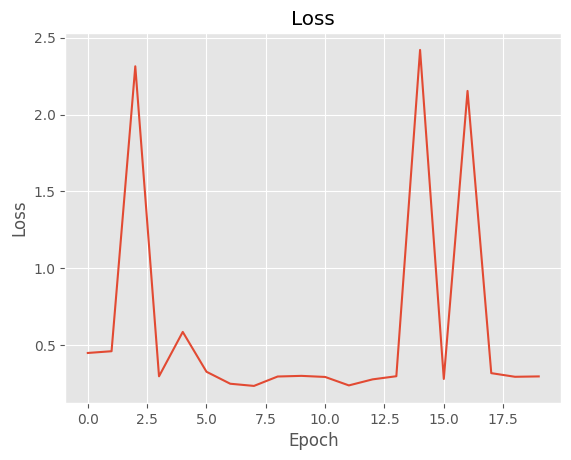

In [18]:

plt.plot(loss_list)
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


# Evaluating the model


In [13]:

class CustomTest(Dataset):
    def __init__(self, img_folder, annotations_file, results_file, transform=None):
        self.img_folder = img_folder
        self.transform = transform
        self.annotations = self.load_json(annotations_file)
        self.results = self.load_json(results_file)
        self.img_ids = [img['id'] for img in self.annotations['images']]

    @staticmethod
    def load_json(filename):
        with open(filename) as f:
            return json.load(f)

    def load_image(self, file_path):
        image = Image.open(file_path).convert('RGB')
        return image

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        img_info = next(img for img in self.annotations['images'] if img['id'] == img_id)
        img_path = f"{self.img_folder}/{img_info['file_name']}"
        image = self.load_image(img_path)

        results = [res for res in self.results if res['image_id'] == img_id]

        pred_boxes, pred_labels = [], []

        for result in results:
            pred_box = result['bbox']
            pred_boxes.append([pred_box[0] / 640, pred_box[1] / 640, (pred_box[0] + pred_box[2]) / 640, (pred_box[1] + pred_box[3]) / 640])
            pred_labels.append(result['category_id'])

        if results == []:
            pred_boxes = [[0, 0, 0, 0]]
            pred_labels = [2]

        
        if self.transform:
            image = self.transform(image)

        input_data = {
            'id' : img_id,
            'image': image,
            'pred_boxes': torch.tensor(pred_boxes, dtype=torch.float32),
            'pred_labels': torch.tensor(pred_labels, dtype=torch.int64),
        }


        return input_data

# Usage example
transform = transforms.Compose([
    transforms.Resize((640, 640)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
annotations_file = '/Users/mohitkumar/Desktop/new model/_annotations.coco.json'
results_file = '/Users/mohitkumar/Desktop/new model/filtered_data_all_images_improvement.json'
img_folder = '/Users/mohitkumar/Desktop/new model/valid'


def custom_collate_fn2(batch):
    max_boxes = 0
    for item in batch:
        max_boxes = max(max_boxes, len(item['pred_boxes']))
    for item in batch:
        current_pred_boxes = len(item['pred_boxes'])
        if current_pred_boxes < max_boxes:
            padding = max_boxes - current_pred_boxes
            item['pred_boxes'] = torch.cat([item['pred_boxes'], torch.zeros(padding, 4)])
            item['pred_labels'] = torch.cat([item['pred_labels'], torch.full((padding,), 2, dtype=torch.int64)])
            
    # Use the default collate function to do the actual batching
    return default_collate(batch)

dataset = CustomTest(img_folder, annotations_file, results_file, transform)
data_loader = DataLoader(dataset, batch_size=1, shuffle=True, collate_fn=custom_collate_fn2)

for inputs in data_loader:
    print(inputs['id'])
    print(inputs['image'].shape)
    print(inputs['pred_boxes'].shape)
    print(inputs['pred_labels'].shape)
    break

tensor([35])
torch.Size([1, 3, 640, 640])
torch.Size([1, 1, 4])
torch.Size([1, 1])


In [24]:

model.eval()

# Load the test data
results = []

with torch.no_grad():
    for inputs in data_loader:
        image_id = inputs['id']
        input_image = inputs['image'].to(device)
        input_boxes = inputs['pred_boxes'].to(device)
        input_labels = inputs['pred_labels'].to(device)
        
        
        box_outputs, class_outputs = model(input_image, input_boxes, input_labels)

        class_probs = F.softmax(class_outputs, dim=-1)  # Convert logits to probabilities
        _, predicted_classes = torch.max(class_probs, dim=-1)
        
        valid_classes_mask = (predicted_classes == 0) | (predicted_classes == 1) 
        filtered_boxes = box_outputs[valid_classes_mask].cpu().numpy()
        filtered_classes = predicted_classes[valid_classes_mask].cpu().numpy()
        filtered_scores = class_probs[valid_classes_mask].cpu().numpy()
        
        max_scores = np.max(filtered_scores, axis=1)
        for i in range(len(filtered_boxes)):
            #convert bbox to xywh and multiply by 640
            filtered_boxes[i][0] = filtered_boxes[i][0] * 640
            filtered_boxes[i][1] = filtered_boxes[i][1] * 640
            filtered_boxes[i][2] = (filtered_boxes[i][2] * 640 )- filtered_boxes[i][0]
            filtered_boxes[i][3] = (filtered_boxes[i][3] * 640) - filtered_boxes[i][1]
            #imageid tensor to int
            # print(type(image_id.item()))
            id = image_id.item()
            result = {
                'image_id': id,  # make sure this is the correct ID for each image
                'category_id': int(filtered_classes[i]),
                'bbox': [float(box) for box in filtered_boxes[i]],  # Convert bbox coords to float, COCO format [x, y, width, height]
                'score': float(max_scores[i])
            }
            results.append(result)
            
#sort the results by image id
results = sorted(results, key=lambda x: x['image_id'])



In [15]:

# results to json
with open('/Users/mohitkumar/Desktop/new model/filtered_data_all_images_improvement.json', 'w') as f:
    json.dump(results, f)
print(results)
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
annotations = '/Users/mohitkumar/Desktop/new model/_annotations.coco.json'

cocoGt = COCO(annotations)
cocoDt = cocoGt.loadRes(results)

cocoEval = COCOeval(cocoGt, cocoDt, 'bbox')
cocoEval.params.catIds = [0, 1] 
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()

        


[{'image_id': 0, 'category_id': 0, 'bbox': [137.36985778808594, 120.31452178955078, 351.4300842285156, 453.47491455078125], 'score': 0.9995105266571045}, {'image_id': 6, 'category_id': 0, 'bbox': [106.10553741455078, 102.92655944824219, 318.24322509765625, 412.0594787597656], 'score': 0.9924830794334412}, {'image_id': 7, 'category_id': 0, 'bbox': [125.94078826904297, 109.66121673583984, 321.5885009765625, 425.7093811035156], 'score': 0.9979779124259949}, {'image_id': 8, 'category_id': 0, 'bbox': [103.0595703125, 98.18904113769531, 302.4662780761719, 399.08184814453125], 'score': 0.9868329167366028}, {'image_id': 14, 'category_id': 0, 'bbox': [113.122314453125, 98.51667785644531, 291.4322509765625, 396.930419921875], 'score': 0.9908532500267029}, {'image_id': 16, 'category_id': 0, 'bbox': [138.55084228515625, 121.67858123779297, 355.59857177734375, 457.1174621582031], 'score': 0.9995879530906677}, {'image_id': 27, 'category_id': 0, 'bbox': [137.90121459960938, 124.49166870117188, 367.99